# Perplexity biomarker using transformers
---

In [1]:
import numpy  as np
import pandas as pd
import math
import os

# pip install transformers torch --upgrade
from transformers  import AutoTokenizer, AutoModelForCausalLM
from tqdm.notebook import tqdm
from time          import time

import scipy.stats       as stats
import matplotlib.pyplot as plt

In [2]:
from utils.log_helpers     import * 
from utils.data_prep       import * 
from utils.transformer_ppl import * 
from utils.evaluation      import *

/Users/andrewmurphy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/andrewmurphy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Data paths

In [3]:
BASE = "../../../turn-taking"
TRANSCRIPTIONS = f"{BASE}/DementiaBank_Transcriptions"
MMSE_PATH      = f"{BASE}/temporal_biomarker/dx-mmse.csv"

---
# Results


| Model      | Win  | Step | Time | Aggr   | MinTok | \| | Score  | Outliers | \|  | Welch p | M-W u   | Hedges g | Cliff's δ |
|-----------:|:----:|:----:|:----:|:------:|:--:|:--:|:----:|:----:|:--:|:-------:|:-------:|:--------:|:--------|
| distilgpt2 | 128 | 16 | 0:00  | winsor | 6 | \| | aNLL | trim | \| |  0.0441 |  0.0358 | -0.3166 | -0.1901 | 
| distilgpt2 | 128 | 16 | 0:00  | winsor | 6 | \| | aNLL | none | \| |  0.2758 |  0.0800 | -0.1602 | -0.1488 | 
| distilgpt2 | 128 | 16 | 0:00  | winsor | 6 | \| | PPL | trim | \| |  0.0762 |  0.0358 | -0.2750 | -0.1901 | 
| distilgpt2 | 128 | 16 | 0:00  | winsor | 6 | \| | PPL | none | \| |  0.5623 |  0.0800 | -0.0866 | -0.1488 |
| gpt2-medium | 16 | 4 | 05:19  | winsor | 6 | \| | aNLL | trim | \| |  0.0554 |  0.0539 | -0.2979 | -0.1746 | 
| gpt2-medium | 16 | 4 | 05:19  | winsor | 6 | \| | aNLL | none | \| |  0.4881 |  0.1213 | -0.1012 | -0.1318 | 
| gpt2-medium | 16 | 4 | 05:19  | winsor | 6 | \| | PPL | trim | \| |  0.0541 |  0.0539 | -0.2952 | -0.1746 | 
| gpt2-medium | 16 | 4 | 05:19  | winsor | 6 | \| | PPL | none | \| |  0.7695 |  0.1213 | -0.0440 | -0.1318 |
| gpt2-medium | 1024 | 256 | 00:47  | winsor | 6 | \| | aNLL | trim | \| |  0.0071 |  0.0088 | -0.4238 | -0.2371 | 
| gpt2-medium | 1024 | 256 | 00:47  | winsor | 6 | \| | aNLL | none | \| |  0.1415 |  0.0303 | -0.2165 | -0.1842 | 
| gpt2-medium | 1024 | 256 | 00:47  | winsor | 6 | \| | PPL | trim | \| |  0.0106 |  0.0088 | -0.3924 | -0.2371 | 
| gpt2-medium | 1024 | 256 | 00:47  | winsor | 6 | \| | PPL | none | \| |  0.4931 |  0.0303 | -0.1042 | -0.1842 | 
| **gpt2-medium** | **256** | **16** | 00:35  | winsor | **3** | \| | **aNLL** | trim | \| |  **0.0050** |  **0.0070** | **-0.4396** | **-0.2436** |
| gpt2-medium | 256 | 16 | 00:35  | winsor | 3 | \| | aNLL | none | \| |  0.1142 |  0.0252 | -0.2317 | -0.1899 | 
| gpt2-medium | 256 | 16 | 00:35  | winsor | 3 | \| | PPL | trim | \| |  0.0065 |  0.0070 | -0.4140 | -0.2436 | 
| gpt2-medium | 256 | 16 | 00:35  | winsor | 3 | \| | PPL | none | \| |  0.4121 |  0.0252 | -0.1242 | -0.1899 | 
| openai-community/gpt2 | 256 | 16 | 00:58  | winsor | 3 | \| | aNLL | trim | \| |  0.0153 |  0.0175 | -0.3786 | -0.2147 | 
| openai-community/gpt2 | 256 | 16 | 00:58  | winsor | 3 | \| | aNLL | none | \| |  0.1760 |  0.0486 | -0.1980 | -0.1673 | 
| openai-community/gpt2 | 256 | 16 | 00:58  | winsor | 3 | \| | PPL | trim | \| |  0.0219 |  0.0175 | -0.3492 | -0.2147 | 
| openai-community/gpt2 | 256 | 16 | 00:58  | winsor | 3 | \| | PPL | none | \| |  0.4120 |  0.0486 | -0.1225 | -0.1673 |
| distilgpt2 | 256 | 16 | 00:09  | winsor | 3 | \| | aNLL | trim | \| |  0.0241 |  0.0215 | -0.3535 | -0.2078 | 
| distilgpt2 | 256 | 16 | 00:09  | winsor | 3 | \| | aNLL | none | \| |  0.1899 |  0.0543 | -0.1919 | -0.1633 | 
| distilgpt2 | 256 | 16 | 00:09  | winsor | 3 | \| | PPL | trim | \| |  0.0406 |  0.0215 | -0.3142 | -0.2078 | 
| distilgpt2 | 256 | 16 | 00:09  | winsor | 3 | \| | PPL | none | \| |  0.4090 |  0.0543 | -0.1223 | -0.1633 | 
| gpt2-medium | 256 | 16 | 00:46  | winsor | 3 | \| | aNLL | trim | \| |  0.0050 |  0.0070 | -0.4396 | -0.2436 | 
| gpt2-medium | 256 | 16 | 00:46  | winsor | 3 | \| | aNLL | none | \| |  0.1142 |  0.0252 | -0.2317 | -0.1899 | 
| gpt2-medium | 256 | 16 | 00:46  | winsor | 3 | \| | PPL | trim | \| |  0.0065 |  0.0070 | -0.4140 | -0.2436 | 
| gpt2-medium | 256 | 16 | 00:46  | winsor | 3 | \| | PPL | none | \| |  0.4121 |  0.0252 | -0.1242 | -0.1899 | 

---
# Set parameters

In [4]:
# distilgpt2 is the fastest for testing... "distilgpt2" | "openai-community/gpt2" | "gpt2-medium"
MODEL_ID   = "gpt2-medium"

STRIDE     = 16
MAX_LENGTH = 256
MIN_TOKENS = 3

## Setting up model

In [5]:
DEVICE    = get_device()
tokenizer = AutoTokenizer       .from_pretrained(MODEL_ID)
model     = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

print(f"Using {b(MODEL_ID)} with device: {b(DEVICE)}")

# Set parameters for the calculation
ppl_args = dict(DEVICE=DEVICE, tokenizer=tokenizer, model=model)

Using gpt2-medium with device: mps


---
# Calculate perplexity

In [6]:
# Print params
print(f"Using {b(MODEL_ID)} with device: {b(DEVICE)}")

# Load them all in
t_files = [fname for fname in os.listdir(TRANSCRIPTIONS) if fname[-5:] == ".xlsx"]
progress_bar = tqdm(range(len(t_files)), leave=True, position=0)

# Loop through each file
t0 = time()
results = []
k = 0
for fname in t_files:
    pID = fname.split(".")[0]
    progress_bar.set_description(f"Processing MeetingID: {pID}")
    
    # Load in the transcription & Get just the users utterances 
    txt = pd.read_excel(f"{TRANSCRIPTIONS}/{fname}")
    user_rows = prep_speech(txt)
    if len(user_rows) == 0: continue
    
    # Process the utterances for perplexity?
    scored   = score_utterances(user_rows, stride=STRIDE, max_length=MAX_LENGTH, **ppl_args)    
    res_df   = pd.DataFrame(scored)
    averaged = combine_user_group(res_df, pID, min_tokens=MIN_TOKENS)
    results.append(averaged)
    
    # If printing/debugging
    if False:
        for row in scored:
            print(f"PPL = {row['perplexity']:6.2f} | tokens={row['tokens_scored']:4} | {row['text'][:50]}...")
        print()
        if k == 20: break
        k += 1
    
    progress_bar.update(1)
progress_bar.close()
t1 = time() - t0

# --------------------------------------------------------------------
# Turn results into a DataFrame & add MMSE 
# --------------------------------------------------------------------
perplexity_scores = pd.DataFrame(results)

# Load in MMSE scores
scores = pd.read_csv(MMSE_PATH)
scores = scores[["id", "mmse", "dx"]]

# Merge them together
merged = perplexity_scores.merge(scores, left_on="pID", right_on="id")
print(perplexity_scores.shape, merged.shape)

d0 = merged.copy()
display(d0.head(2))

Using gpt2-medium with device: mps


  0%|          | 0/194 [00:00<?, ?it/s]

(194, 5) (190, 8)


,pID,tokens,avg_nll,ppl,bpt,id,mmse,dx
0,587-0,108,3.817695,45.499196,5.507769,587-0,19.0,ProbableAD
1,293-1,64,5.453282,233.523416,7.867423,293-1,15.0,ProbableAD


---
# Temp Eval code...

────────────────────────────────────────────────────────────────────────────────────────────────────
Metric: Average Negative Log-Likelihood  |  Outliers: trim
────────────────────────────────────────────────────────────────────────────────────────────────────
Control:      3.7274 (+/- 0.3935) | n =  72 ( 82)
ProbableAD:   3.9053 (+/- 0.4098) | n =  96 (108)
Diff:        -0.1779 | 95% CI [-0.2998, -0.0578]

Welch t p =  0.00497  |  Mann-Whitney p =  0.00699
Hedges  g = -0.43962  |  Cliff's      δ = -0.24363


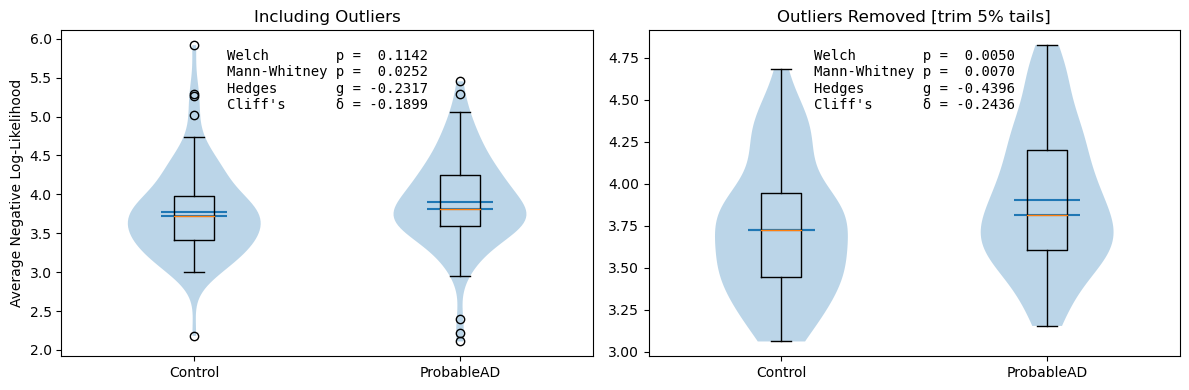

────────────────────────────────────────────────────────────────────────────────────────────────────
Metric: Perplexity  |  Outliers: trim
────────────────────────────────────────────────────────────────────────────────────────────────────
Control:     45.0004 (+/- 19.0776) | n =  72 ( 82)
ProbableAD:  54.1455 (+/- 23.9381) | n =  96 (108)
Diff:        -9.1451 | 95% CI [-15.7467, -2.7032]

Welch t p =  0.00654  |  Mann-Whitney p =  0.00699
Hedges  g = -0.41397  |  Cliff's      δ = -0.24363


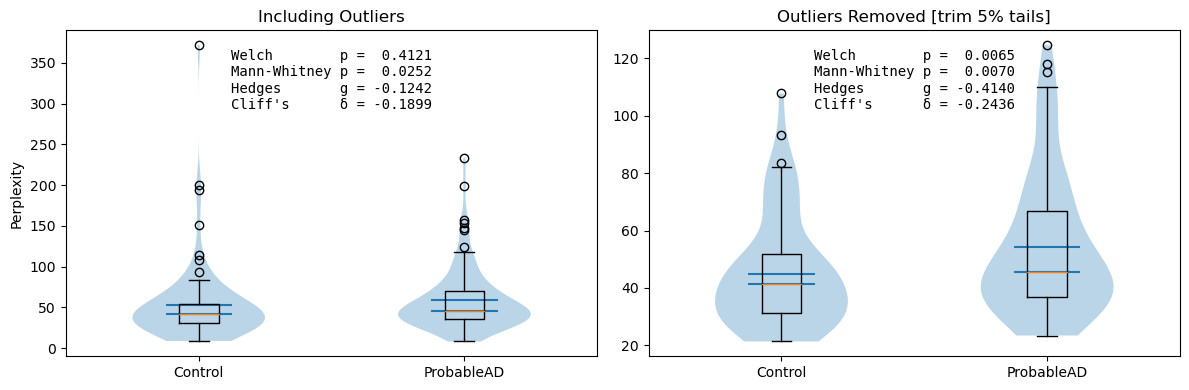

────────────────────────────────────────────────────────────────────────────────────────────────────
Comparison Plots
────────────────────────────────────────────────────────────────────────────────────────────────────


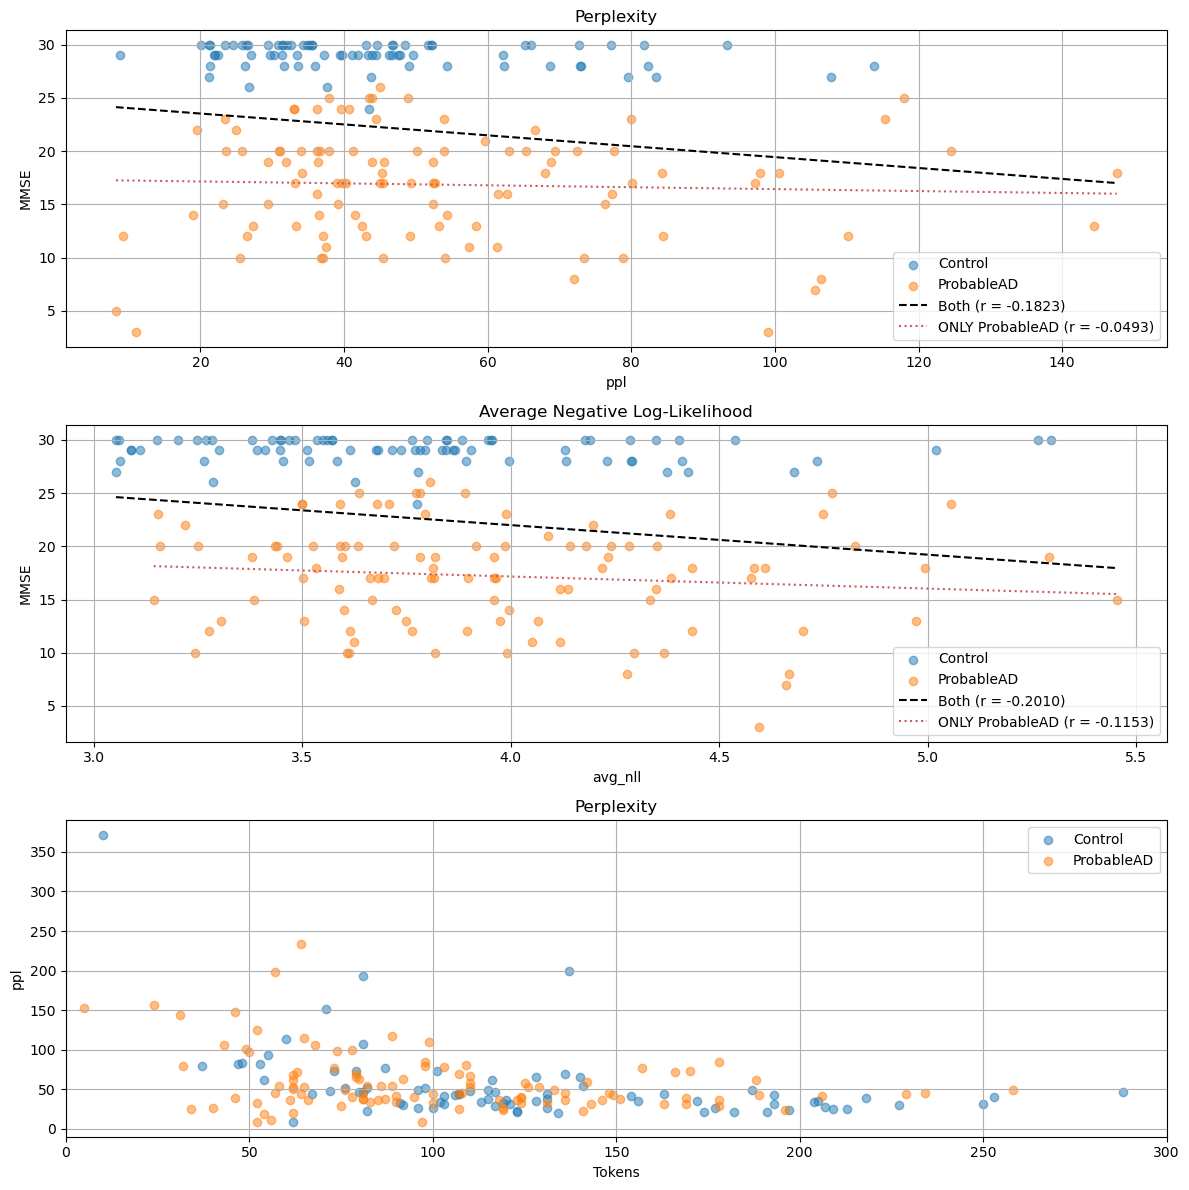



For the results table: 

| gpt2-medium | 256 | 16 | 00:52  | winsor | 3 | \| | aNLL | none | \| |  0.1142 |  0.0252 | -0.2317 | -0.1899 | 
| gpt2-medium | 256 | 16 | 00:52  | winsor | 3 | \| | PPL | none | \| |  0.4121 |  0.0252 | -0.1242 | -0.1899 | 
| gpt2-medium | 256 | 16 | 00:52  | winsor | 3 | \| | aNLL | trim | \| |  0.0050 |  0.0070 | -0.4396 | -0.2436 | 
| gpt2-medium | 256 | 16 | 00:52  | winsor | 3 | \| | PPL | trim | \| |  0.0065 |  0.0070 | -0.4140 | -0.2436 | 


In [7]:
table_meta = dict(
    model_id   = MODEL_ID, 
    stride     = STRIDE, 
    max_length = MAX_LENGTH, 
    runtime_s  = t1,
    aggr       = "winsor",
    min_tokens = MIN_TOKENS,
)
    
comp_args = dict(outliers="trim", trim_q=(0.05, 0.95), title_suffix="[trim 5% tails]", table_meta=table_meta)


x = compare_and_plot(d0, metric="avg_nll", **comp_args)
y = compare_and_plot(d0, metric="ppl",     **comp_args)

_, _ = plot_mmse_panels(d0, token_min=20)


print("\n\nFor the results table: \n")
for line in [x[1],y[1],x[0],y[0]]: print(line)